# Import and Loss

In [1]:
import sys
sys.path.append('../')
sys.path.append('../../')
import matplotlib.pyplot as plt
import numpy as np
import pickle
import torch
import pandas as pd
from sklearn.preprocessing import StandardScaler
from utils import *
from utils_test import *
from models.models import *

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
stock_symbol = '5871.TW'
end_date = '2024-12-31'

num_class = 2
fp16_training = True
decoder = False
short = False
num_epochs = 500

/tmp/ipykernel_118481/2153386001.py:8: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
stock_symbol = '5871.TW'
end_date = '2024-12-31'

model = VT_vit_b_16(num_class).to(device)
Model = model.model_type

total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
"{:.2e}".format(total_params)

'8.66e+07'

### Setting and Model and result

4.053429751626907


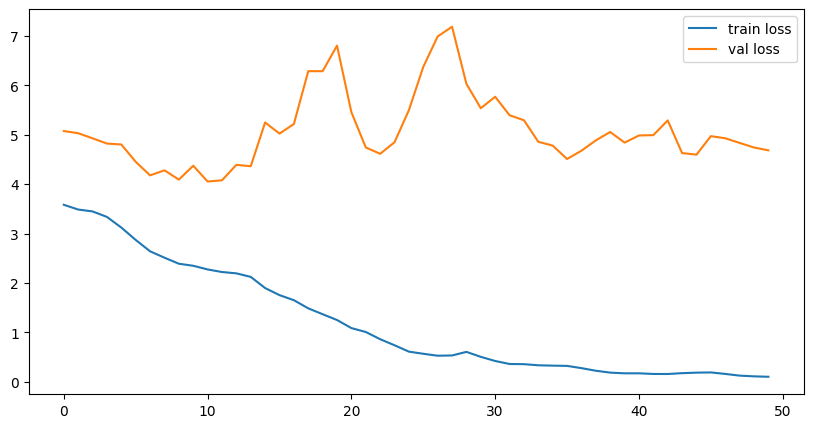

In [3]:
with open(f'Temp/{Model}_class{num_class}_{stock_symbol}_LastTrainInfo.pk', 'rb') as f:
    infos = pickle.load(f)
print(infos['min val loss'])

with open(f'Temp/{Model}_class{num_class}_{stock_symbol}_TrainValHistLoss.pk', 'rb') as f:
    results = pickle.load(f)
train_loss = results['train']
val_loss = results['valid']

plt.figure(figsize=(10, 5))
plt.plot(train_loss[:], label='train loss')
plt.plot(val_loss[:], label='val loss')
plt.legend()
plt.show()


### Data

In [4]:
if num_class == 2:
    with open('../DataLoader/dataloader.pk', 'rb') as f:
        data = pickle.load(f)
    validloader = data['validloader']
    testloader = data['testloader']
elif num_class == 1:
    with open('../DataLoader/dataloader_1.pk', 'rb') as f:
        data = pickle.load(f)
    validloader = data['validloader']
    testloader = data['testloader']
with open('../DataLoader/dates.pk', 'rb') as f:
    dates = pickle.load(f)
with open('../DataLoader/data_clean.pk', 'rb') as f:
    df = pickle.load(f)
with open('../DataLoader/src.pk', 'rb') as f:
    src = pickle.load(f)
    
date_test = dates['test']
src = src.permute(2, 0, 1).to(device)
    
# ====================
# Valid 
x_valid = []
for x, y in validloader:
    x_valid.append(x)
x_valid = torch.cat(x_valid, dim = 0)

# ====================
# Check
for x, y in testloader:
    print(x.shape)
    break

torch.Size([8, 5, 224, 224])


# Backtest 

### Function

In [5]:
def backtest_plot(i):
    global short, num_class
    
    # Prediction
    model.load_state_dict(torch.load(f'Result/{Model}_class{num_class}_{stock_symbol}_best_model.pt'))
    model.eval()    
    y_pred, acc = test(model, testloader)
    y_train_pred, acc = test(model, validloader)
    y_pred_numpy = y_pred.cpu().numpy()
    prediction = pd.DataFrame(y_pred_numpy)
        
    # Scaling with predicted valid set
    y_train_numpy = y_train_pred.detach().cpu().numpy()
    scaler = StandardScaler()
    scaler.fit(y_train_numpy)
    prediction = pd.DataFrame(scaler.transform(prediction))
    
    # Column name
    if num_class == 1:
        prediction.columns = ['pred_doc_1']
    else:
        prediction.columns = ['pred_do_1', 'pred_dc_1']

    # Merge on date. 
    # In Encoder Decoder need to ignore the last batch if last batch's batch size != batch_size
    # so use date_test[:len(prediction)]
    prediction['Date'] = date_test[:len(prediction)]
    true_and_pred = pd.merge(df.reset_index(), prediction, on = 'Date', how = 'left')
    
    # Close is normalised while use Close in training, set Close to original
    true_and_pred['Close'] = true_and_pred['Close_origin']
    
    # Get the predicted doc_1. If class == 1 the the y_pred is the doc_1
    """
    NOTE:
    1. Use today's data predict tmr's
    2. y is y * 100. /= 100 here
    3. d~ is all percentile change
    """
    if num_class == 2:
        true_and_pred['pred_o'] = (true_and_pred['Open'] * (1 + true_and_pred['pred_do_1']/100))
        true_and_pred['pred_c'] = (true_and_pred['Close'] * (1 + true_and_pred['pred_dc_1']/100))
        true_and_pred['pred_doc_1'] = \
            (true_and_pred['pred_c'] - true_and_pred['pred_o'])/true_and_pred['pred_o']
    elif num_class == 1:
        true_and_pred['pred_doc_1'] /= 100
    true_and_pred['doc_1'] /= 100
    
    # Backtest
    """
    NOTE:
    For encoder-only and encoder-decoder since the second one need to drop last, 
    buy hold would not be the same
    """
    asset_list = []
    if num_class == 2:
        df_backtest = true_and_pred[['Open', 'Close', 'doc_1', 'pred_doc_1', 'pred_do_1', 'pred_dc_1']].dropna()
        acc = (np.sign(df_backtest['pred_doc_1'])==np.sign(df_backtest['doc_1'])).sum()/len(df_backtest)
        asset = 1
        asset_buyhold = 1
        for index, (o, c, true, pred, _, _) in df_backtest.iterrows():
            if pred > 0.004:
                asset *= (1 + true)   
            if short and pred < -0.004:
                asset *= (1 - true)   
            asset_buyhold *= (1 + true)
            asset_list.append(asset)
        print(f'Buy Hold last asset: {asset_buyhold}')
    else:
        df_backtest = true_and_pred[['Close', 'pred_doc_1', 'doc_1']].dropna()
        acc = (np.sign(df_backtest['pred_doc_1'])==np.sign(df_backtest['doc_1'])).sum()/len(df_backtest)
        asset = 1
        asset_buyhold = 1
        for index, (c, pred, true) in df_backtest.iterrows():
            # print(pred, true)
            if pred > 0.004:
                asset *= (1 + true)
            if short and pred < -0.004:
                asset *= (1 - true)
            asset_buyhold *= (1 + true)
            asset_list.append(asset)
        print(f'Buy Hold last asset: {asset_buyhold}')

    print(f'Accuracy: {acc}')
    print(f'Asset: {asset}')
    plt.subplot(int(np.ceil(trials/2)), 2, i + 1)
    plt.plot(asset_list, label = 'model')
    plt.plot(df_backtest.reset_index()['Close']/df_backtest['Close'].iloc[0], label = 'buy hold')
    plt.legend()
    return y_pred, df_backtest

### Backtest

100%|██████████| 62/62 [00:07<00:00,  8.57it/s]


Buy Hold last asset: 0.8648769047530993
Accuracy: 0.41025641025641024
Asset: 0.9982235454707348


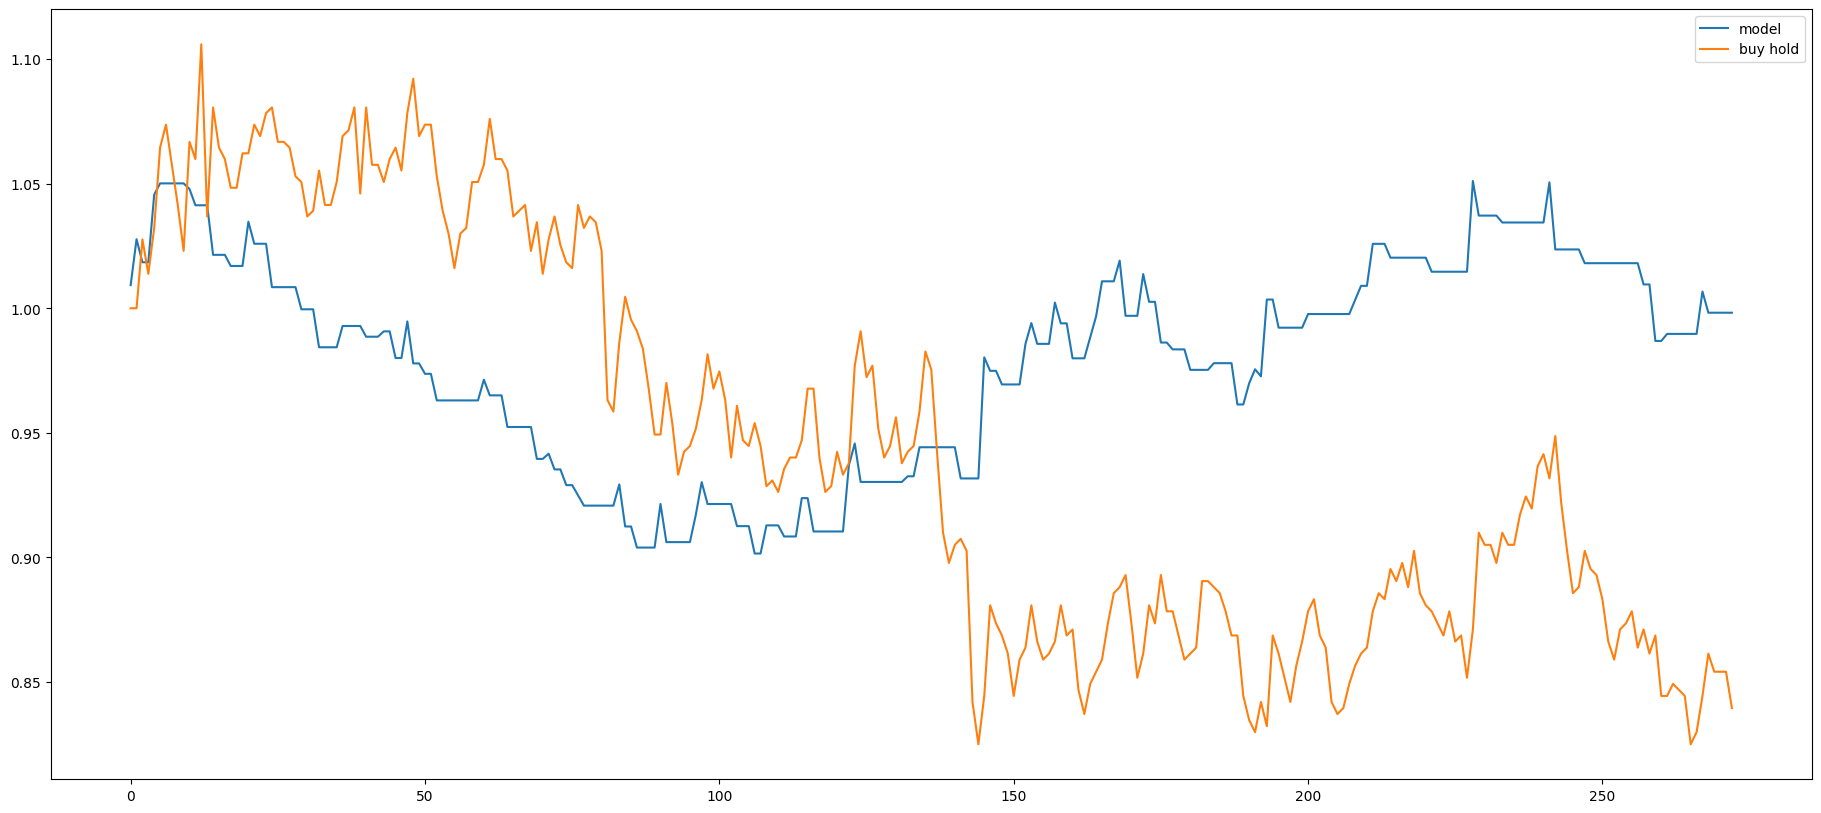

In [6]:
trials = 1
plt.figure(figsize = (50, 10))
for i in range(trials):
    torch.cuda.empty_cache()
    y_pred, df_b = backtest_plot(i)
plt.savefig(f'Result/{Model}_class{num_class}_{stock_symbol.split(".")[0]}_backtest')
torch.cuda.empty_cache()
    

In [7]:
df_b

,Open,Close,doc_1,pred_doc_1,pred_do_1,pred_dc_1
2677,204.168945,206.068192,0.009302,0.015792,-0.283483,0.357641
2678,204.168945,206.068192,0.018265,0.006860,-0.300273,-0.541526
2679,207.967437,211.765930,-0.009009,0.017105,0.562482,0.447960
2680,210.816300,208.917053,0.004484,-0.008254,-1.322058,-1.246863
2681,211.765922,212.715546,0.026667,0.013694,-0.059193,0.857153
...,...,...,...,...,...,...
2945,174.500000,177.500000,-0.008451,0.013717,0.719179,0.375108
2946,177.500000,176.000000,-0.002833,-0.015014,-0.702804,-1.360063
2947,176.500000,176.000000,0.002849,-0.005309,0.313563,0.064503
2948,175.500000,176.000000,-0.017045,-0.001067,-0.089938,-0.480109


In [8]:
stock_symbol.split('.')[0]

'5871'